This notebook discusses the current E(Q) kernel implementation that picks the Q magnitude first. After that, the energy and momentum conservation relations can be used to determine the polar angle of $k_f$, and then the azimuthal angle can be picked randomly to determine the direction of scattering. 

This method is faster, but the current implementation misses one initial step to determine the dynamical range of Q magnitude. This $Q$ range (instead of the simple Qmax-Qmin) should be used in [the last step](https://github.com/mcvine/mcvine/blob/24e2e45f46ecf6d4a422556fbba00d7ca9c74ed3/packages/mccomponents/lib/kernels/sample/E_Q_Kernel.icc#L210) to adjust the probability. 

We start with the double differential cross section
\begin{equation}
\frac{d^2 \sigma}{d\Omega dE_f} =
\frac{\sigma}{4\pi}
\frac{k_f}{k_i}
N S(Q,E)
\end{equation}

\begin{equation}
 S(Q,E) = S(Q) \times \delta(E-E(Q))
\end{equation}

For now, only consider the part that we need for MC integration

\begin{align}
S(Q,E){d\Omega dE_f} & \propto S(Q) \times \delta(E-E(Q)) {d\Omega dE_f} \\
& \propto \delta(E-E(Q)) {d\Omega dE_f}
\end{align}

Because

\begin{align}
d^3 k_f &= k_f^2 dk_f d\Omega = \frac{1}{2} k_f d{k_f^2} d\Omega = k_f \frac{m}{\hbar^2} dE_f d\Omega\\
dE_f d\Omega &= \frac{\hbar^2}{m k_f} d^3 k_f
\end{align}

the integration can be transformed:
\begin{align}
I = \delta(E-E(Q)) dE_f d\Omega &= \delta(E-E(Q)) \frac{\hbar^2}{m k_f} d^3 k_f
\end{align}

Since $d^3 k_f = d^3 Q$, we have
\begin{align}
I &= \frac{\hbar^2}{m k_f} \delta(E-E(Q)) d^3 Q
\end{align}


But
\begin{align}
d^3 Q &= Q^2 dQ \sin\theta d\theta \; d\phi
\end{align}

where $\theta$ is angle between $k_i$ and $Q$, the polar angle (note: this is different from the polar angle we mentioned earlier, which is the angle between $k_i$ and $k_f$), and $\phi$ is the azimuthal angle

From 

\begin{align}
k_f^2 &= Q^2 + k_i^2 - 2 Q k_i \cos\theta
\end{align}

and the fact that we select Q first, 
we got

\begin{align}
2Qk_i \sin\theta d\theta = \frac{2m}{\hbar^2} dE_f
\end{align}


Therefore,

\begin{align}
d^3 Q &= Q^2 dQ 2\pi \frac{m}{\hbar^2 Q k_i} dE_f
\end{align}

\begin{align}
I &= \frac{2\pi Q}{k_i k_f} \delta(E-E(Q)) dQ dE_f
\end{align}

If considering the factor $\frac{1}{4\pi}$, we got

\begin{align}
I &= \frac{Q}{2 k_i k_f} \delta(E-E(Q)) dQ dE_f
\end{align}

The implementation can be found [here](https://github.com/mcvine/mcvine/blob/24e2e45f46ecf6d4a422556fbba00d7ca9c74ed3/packages/mccomponents/lib/kernels/sample/E_Q_Kernel.icc).

In [1]:
import os, numpy as np
import mcni
from mcni.utils import conversion
from mccomponents import mccomponentsbp
import histogram.hdf as hh, histogram as H

In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook

# Simulation using E_Q_kernel

In [3]:
kernel = mccomponentsbp.create_E_Q_Kernel("0", "1", 0, 25, 1., 1.)

In [4]:
vi = np.array((0,0,8000))
ki =conversion.v2k(np.linalg.norm(vi))
print ki

12.706039537


In [5]:
%%time
N = 100000
Qs = []; vfs = []; probs = []
for i in range(N):
    n = mcni.neutron(v=vi)
    kernel.scatter(n)
    vf = np.array(n.state.velocity)
    vdiff = vi - vf
    vdiff_mag = np.linalg.norm(vdiff)
    Q = conversion.v2k(vdiff_mag)
    p = n.probability
    Qs.append(Q); vfs.append(vf); probs.append(p)
    continue

CPU times: user 10.2 s, sys: 12 ms, total: 10.2 s
Wall time: 10.2 s


## histogram

In [6]:
dQ = 0.1

In [7]:
hist, Qbb = np.histogram(Qs, weights=probs, bins=np.arange(0, 2*ki, dQ))

In [8]:
Qcenters = (Qbb[1:] + Qbb[:-1])/2

<IPython.core.display.Javascript object>


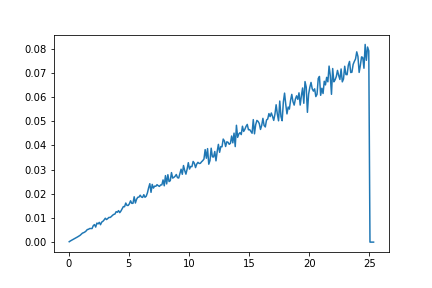

In [9]:
plt.figure()
plt.plot(Qcenters, hist/N/dQ)

This should match IsotropicKernel and it does.

# Simulation of a sin wave using E_Q_kernel

In [10]:
kernel = mccomponentsbp.create_E_Q_Kernel("20+30*sin(Q/2.*3.14159)^2", "1", 0, 25, 1., 1.)

In [11]:
vi_vector = np.array((0,0,4000))
vi = np.linalg.norm(vi_vector)
ki =conversion.v2k(vi)
print ki
Ei = conversion.v2e(vi)
print Ei

6.35301976852
83.632620117


In [12]:
%%time
N = 100000
Qs = []; Es = []; vfs = []; probs = []
for i in range(N):
    n = mcni.neutron(v=vi_vector)
    kernel.scatter(n)
    vf_vector = np.array(n.state.velocity)
    vf = np.linalg.norm(vf_vector)
    Ef = conversion.v2e(vf)
    E = Ei - Ef; Es.append(E)
    vdiff_vector = vi_vector - vf_vector
    vdiff = np.linalg.norm(vdiff_vector)
    Q = conversion.v2k(vdiff)
    p = n.probability
    Qs.append(Q); vfs.append(vf_vector); probs.append(p)
    continue

CPU times: user 13.5 s, sys: 2.69 s, total: 16.2 s
Wall time: 16.2 s


## histogram

In [13]:
dQ = 0.05; dE=.25

In [14]:
hist, Qbb, Ebb = np.histogram2d(Qs, Es, weights=probs, bins=(np.arange(0, 2*ki, dQ), np.arange(0, Ei, dE)))

In [15]:
Qcenters = (Qbb[1:] + Qbb[:-1])/2
Ecenters = (Ebb[1:] + Ebb[:-1])/2

<IPython.core.display.Javascript object>


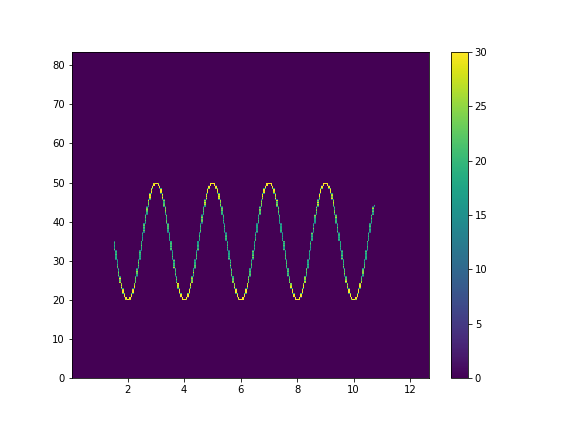

In [16]:
plt.figure(figsize=(8,6))
Qmesh,Emesh = np.meshgrid(Qcenters, Ecenters)
plt.pcolormesh(Qmesh, Emesh, hist.T/Qmesh)  # /Qmesh is equivalent to solid angle normalization. See IstropicKernel
plt.clim(0, 30)
plt.colorbar()